In [ ]:
!pip install wandb
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets, models, transforms
import time
import random
import torchvision
import copy
import wandb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.gridspec as gridspec
from skimage.segmentation import mark_boundaries
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

img_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        torchvision.transforms.Lambda(nhwc_to_nchw),
        #torchvision.transforms.Lambda(lambda x: x*(1/255)),
        transforms.Normalize(mean = mean, std = std),
        torchvision.transforms.Lambda(nchw_to_nhwc)
            ])


inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean=[0, 0, 0],
        std=[1/(0.5), 1/(0.5), 1/(0.5)]
    ),
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    inv_normalize
])



In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    Set requires_grad attribute of the parameters in the model to False if feature_extracting is True,
    allowing only the last layer to be learned during training if desired.

    Inputs:
        model (nn.Module): neural network model
        feature_extracting (bool): if True, only the last layer is learned during training

    Outputs:
        None
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, weights):
    """
    Initializes a pre-trained model for fine-tuning on a new classification task.

    Args:
        model_name (str): Name of the model architecture to use, e.g., "resnet".
        num_classes (int): Number of classes in the new classification task.
        feature_extract (bool): Whether to freeze all model parameters except the final layer.
        weights (str): Path to the pre-trained weights file or one of {"imagenet", None}.

    Returns:
        model_ft (nn.Module): The initialized model with a new final layer for num_classes.
        input_size (int): The expected size of the input images for the model.
    """

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet
        """
        #model_ft = models.resnet18(weights=weights)
        model_ft = models.resnet50(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [ ]:
model_name = "resnet"
NUM_CLASSES = 3
BATCH_SIZE = 32
WEIGHTS = "ResNet50_Weights.IMAGENET1K_V2" #ResNet50 weights
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

trained_model, input_size = initialize_model(model_name, NUM_CLASSES, feature_extract, weights=WEIGHTS)
model_path = "./drive/MyDrive/BT5153 Applied Project/trained_models/resnet50_fe.pth" #change file name here
trained_model.load_state_dict(torch.load(model_path, map_location=device))
trained_model.to(device)
trained_model.eval
print(model_path)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.8MB/s]


./drive/MyDrive/BT5153 Applied Project/trained_models/resnet50_fe.pth


In [ ]:
path = "./drive/MyDrive/BT5153 Applied Project/Meat Freshness.v1-new-dataset.multiclass/SHAP Images/Test"
originals = []
images = []
labels = []
for img in os.listdir(path):
  originals.append(Image.open(os.path.join(path, img)))
  images.append(img_transform(Image.open(os.path.join(path, img))))
  labels.append(img.split('-')[0])

dataloader = DataLoader(images, batch_size = 1, shuffle = False)

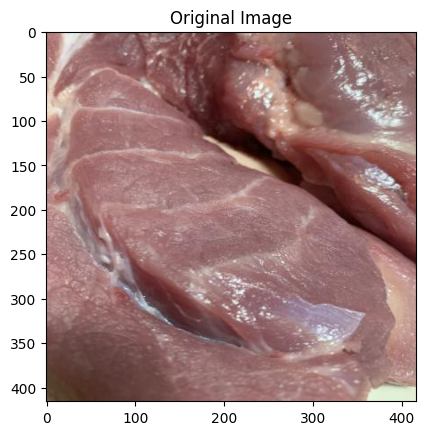

In [ ]:
plt.imshow(originals[0])
plt.title('Original Image')
plt.show()

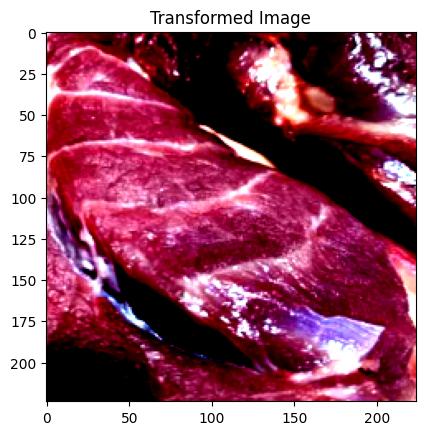

In [ ]:
plt.imshow(images[0])
plt.title('Transformed Image')
plt.show()

In [ ]:
t_originals = []
t_images = []
t_labels = []
for img in os.listdir(path):
  t_originals.append(Image.open(os.path.join(path, img)))
  t_images.append(test_transform(Image.open(os.path.join(path, img))))
  t_labels.append(img.split('-')[0])

In [ ]:
# def predict(img):
#     img = torch.Tensor(img)
#     img = nhwc_to_nchw(img)
#     img = img.to(device)#.unsqueeze(0)
#     output = trained_model(img)

#     output = output.detach().cpu().numpy()
#     return output

# def predict(img) -> torch.Tensor:
#     img = torch.Tensor(img)
#     img = nhwc_to_nchw(img)
#     img = img.to(device).unsqueeze(0)
#     output = trained_model(img)
#     return output

def t_predict_old(img) -> torch.Tensor:
    trained_model.eval()
    with torch.set_grad_enabled(False):
        img = torch.Tensor(img)
        img = nhwc_to_nchw(img)
        #img = img.unsqueeze(0)
        img  = img.to(device)
        output = trained_model(img)
    return output.detach().cpu().numpy()

def t_predict(img) -> torch.Tensor:
    trained_model.eval()
    with torch.set_grad_enabled(False):
        m = nn.Softmax(dim=1)
        img = torch.Tensor(img)
        img = nhwc_to_nchw(img)
        #img = img.unsqueeze(0)
        img  = img.to(device)
        output = trained_model(img)
        output = m(output)
    return output.detach().cpu().numpy()

def s_predict(img) -> torch.Tensor:
    trained_model.eval()
    with torch.set_grad_enabled(False):
      m = nn.Softmax(dim=1)
      img = torch.Tensor(img)
      img = nhwc_to_nchw(img)
      img = img.unsqueeze(0)
      img  = img.to(device)
      output = trained_model(img)
      output = m(output)
    return output

In [ ]:
# Checking if prediction works
index = 0
output = s_predict(images[index])
preds = torch.argmax(output)
print(labels[index])
print(output)
print(preds.detach().cpu().numpy())

FRESH
tensor([[0.1589, 0.1816, 0.6596]])
2


In [ ]:
def predict_label(img):
  output = s_predict(img)
  proba = output.detach().cpu().numpy().reshape(-1)
  spoiled = proba[0] 
  half = proba[1]
  fresh = proba[2]
  print(f"Probabilities\nSPOILED: {spoiled}\nHALF-FRESH: {half}\nFRESH: {fresh}")
  preds = torch.argmax(output)
  if preds == 2:
    return "FRESH"
  elif preds == 1:
    return "HALF-FRESH"
  else:
    return "SPOILED"


In [ ]:
label = predict_label(images[index])
print(label)

Probabilities
SPOILED: 0.15885549783706665
HALF-FRESH: 0.18157422542572021
FRESH: 0.6595703363418579
FRESH


In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()
index = 0
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Probabilities
SPOILED: 0.15885549783706665
HALF-FRESH: 0.18157422542572021
FRESH: 0.6595703363418579


  0%|          | 0/1000 [00:00<?, ?it/s]

Probabilities
SPOILED: 0.1781122386455536
HALF-FRESH: 0.5199753046035767
FRESH: 0.301912397146225


  0%|          | 0/1000 [00:00<?, ?it/s]

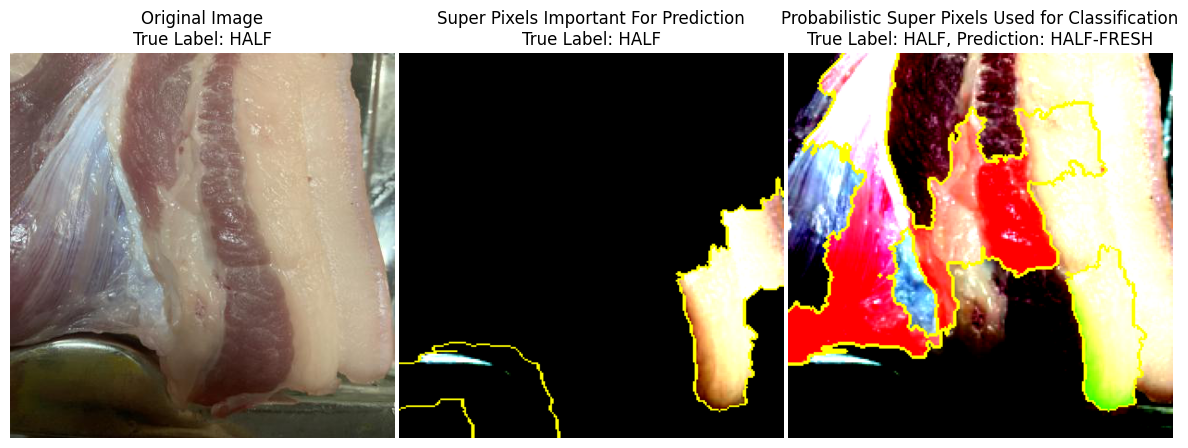

In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()
index = 1
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Probabilities
SPOILED: 0.8773259520530701
HALF-FRESH: 0.09455195814371109
FRESH: 0.0281220730394125


  0%|          | 0/1000 [00:00<?, ?it/s]

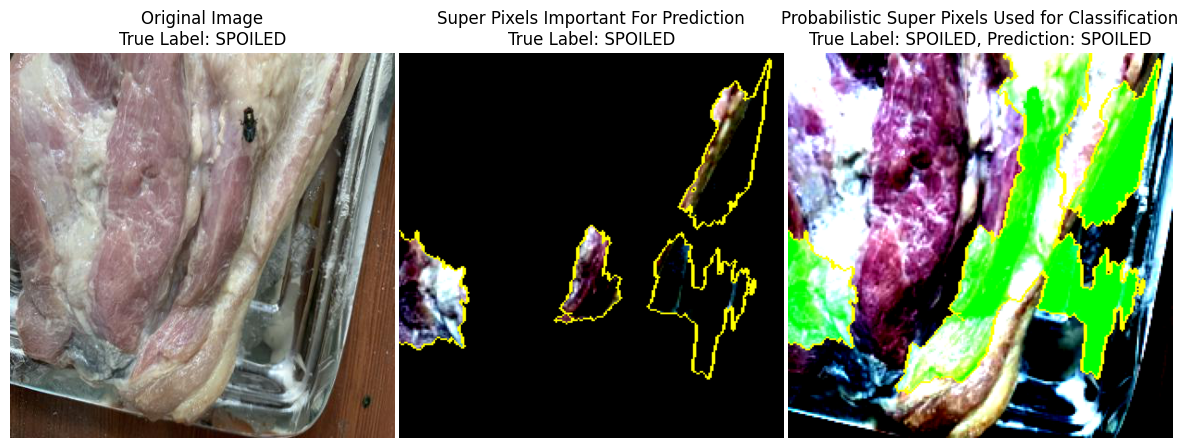

In [ ]:
explainer = lime_image.LimeImageExplainer()
index = 2
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Now we know why our model classifies our image as Fresh. On the left image, we can see that only the super-pixels where the meat is visible are shown. This means that our model classifies our image as a Fresh because of these parts of super-pixels.

On the right image, the area of super-pixels colored in green are the ones that increase the probability of our image belongs to a Fresh class, while the super-pixels colored in red are the ones that decrease the probability.

### Misclassified Images ### 

In [ ]:
path = "./drive/MyDrive/BT5153 Applied Project/Meat Freshness.v1-new-dataset.multiclass/SHAP Images/Misclassified"
originals = []
images = []
labels = []
for img in os.listdir(path):
  originals.append(Image.open(os.path.join(path, img)))
  images.append(img_transform(Image.open(os.path.join(path, img))))
  labels.append(img.split('-')[0])

Probabilities
SPOILED: 0.4973815977573395
HALF-FRESH: 0.4541856050491333
FRESH: 0.048432834446430206


  0%|          | 0/1000 [00:00<?, ?it/s]

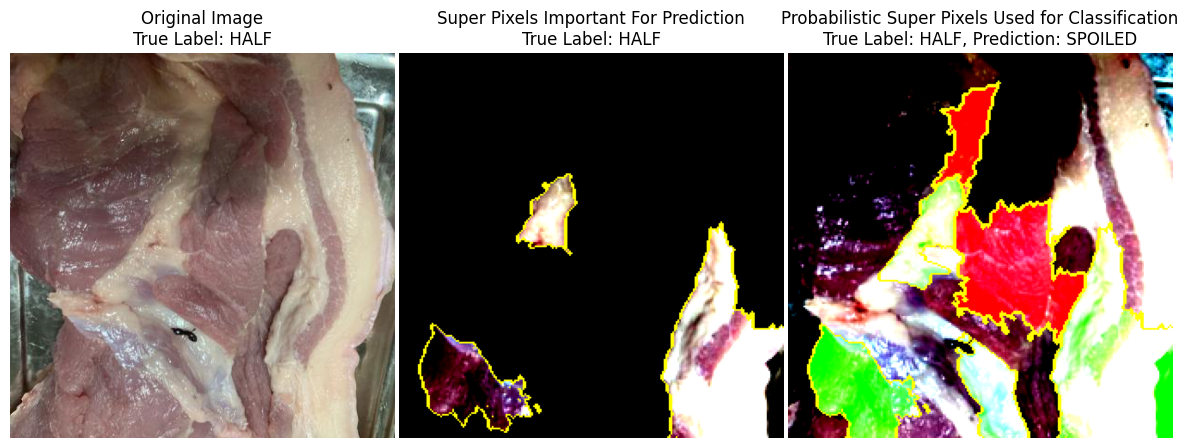

In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()

index = 0
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Probabilities
SPOILED: 0.09910985827445984
HALF-FRESH: 0.32504764199256897
FRESH: 0.5758424997329712


  0%|          | 0/1000 [00:00<?, ?it/s]

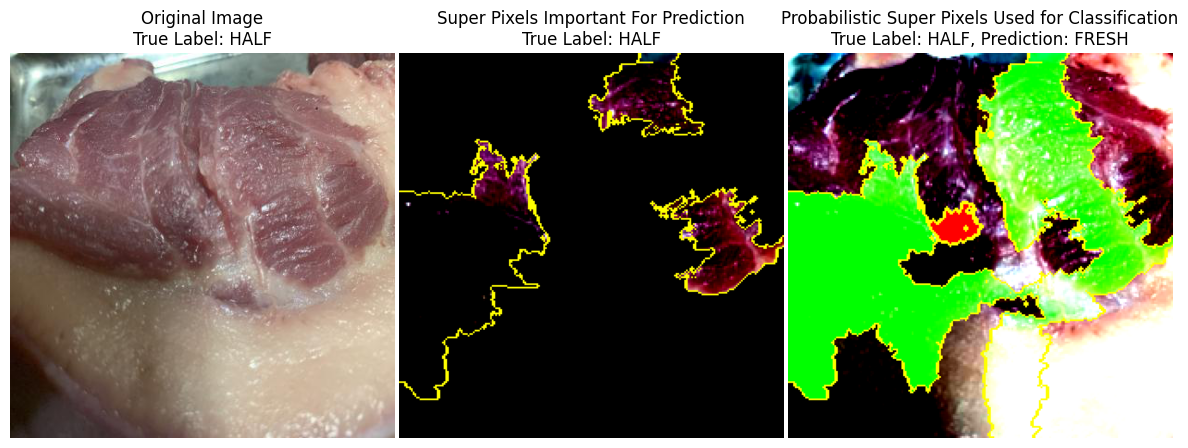

In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()

index = 1
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Probabilities
SPOILED: 0.11202506721019745
HALF-FRESH: 0.520697832107544
FRESH: 0.36727699637413025


  0%|          | 0/1000 [00:00<?, ?it/s]

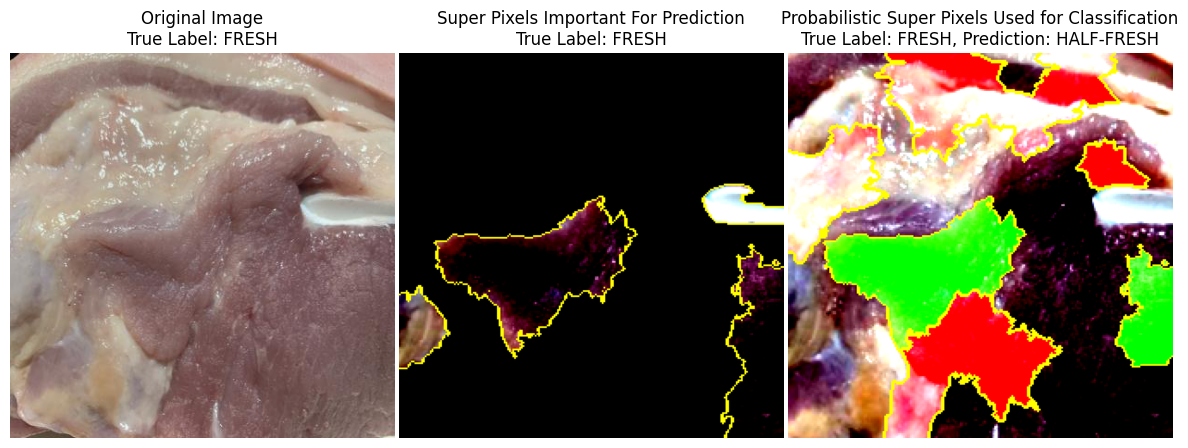

In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()

index = 2
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()

Probabilities
SPOILED: 0.505188524723053
HALF-FRESH: 0.20655207335948944
FRESH: 0.2882593870162964


  0%|          | 0/1000 [00:00<?, ?it/s]

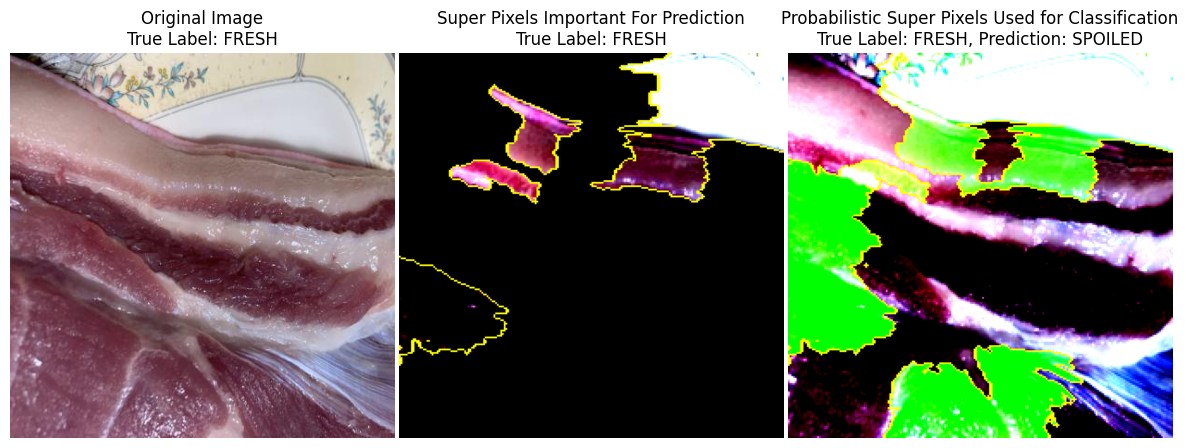

In [ ]:
# With SOFTMAX
# init explainer
explainer = lime_image.LimeImageExplainer()

index = 3
# Convert the PyTorch tensor to a NumPy array
image_np = images[index].detach().cpu().numpy()

prediction = predict_label(image_np)

explanation = explainer.explain_instance(image_np, t_predict,  
                                         top_labels=3, num_samples=1000, random_seed=2023)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
gs.update(wspace=0.01, hspace=0.01)

# Plot 1
ax1 = plt.subplot(gs[0])
ax1.imshow(originals[index])
ax1.set_title(f"Original Image\nTrue Label: {labels[index]}")
ax1.axis('off')

# Plot 2
ax2 = plt.subplot(gs[1])
ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title(f"Super Pixels Important For Prediction\nTrue Label: {labels[index]}")
ax2.axis('off')

# Plot 3
ax3 = plt.subplot(gs[2])
ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title(f"Probabilistic Super Pixels Used for Classification\nTrue Label: {labels[index]}, Prediction: {prediction}")
ax3.axis('off')

plt.show()